#Exercise source
#https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d

# Configuration

In [ ]:
#Parameters
PROJECT_NAME = 'ML1010_Weekly'
ENABLE_COLAB = True

#Root Machine Learning Directory. Projects appear underneath
GOOGLE_DRIVE_MOUNT = '/content/gdrive' 
COLAB_ROOT_DIR = GOOGLE_DRIVE_MOUNT + '/MyDrive/Colab Notebooks'
COLAB_INIT_DIR = COLAB_ROOT_DIR + '/utility_files'

LOCAL_ROOT_DIR = '/home/magni/Documents/ML_Projects'
LOCAL_INIT_DIR = LOCAL_ROOT_DIR + '/utility_files'

# Bootstrap Environment

In [ ]:
#add in support for utility file directory and importing
import sys
import os

if ENABLE_COLAB:
  #Need access to drive
  from google.colab import drive
  drive.mount(GOOGLE_DRIVE_MOUNT, force_remount=True)
  
  #add in utility directory to syspath to import 
  INIT_DIR = COLAB_INIT_DIR
  sys.path.append(os.path.abspath(INIT_DIR))
  
  #Config environment variables
  ROOT_DIR = COLAB_ROOT_DIR
  
else:
  #add in utility directory to syspath to import
  INIT_DIR = LOCAL_INIT_DIR
  sys.path.append(os.path.abspath(INIT_DIR))
  
  #Config environment variables
  ROOT_DIR = LOCAL_ROOT_DIR

#Import Utility Support
from jarvis import Jarvis
jarvis = Jarvis(ROOT_DIR, PROJECT_NAME)

import mv_python_utils as mvutils

Mounted at /content/gdrive
Wha...where am I?
I am awake now.

I have set your current working directory to /content/gdrive/MyDrive/Colab Notebooks/ML1010_Weekly
The current time is 09:25
Hello sir. Extra caffeine may help.



# Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(1337)

%tensorflow_version 1.x
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Sequential
from tensorflow.keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard



TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
jarvis.getPackageVersion('tensorflow')

tensorflow version: tensorflow 2.7.0


# Loading The Data

In [ ]:
jarvis.showProjectDataFiles()
train_raw = pd.read_csv(jarvis.DATA_DIR + '/complaints.csv.gz')
train_raw.head()

[D] /content/gdrive/MyDrive/Colab Notebooks/data/ML1010_Weekly
--> complaints.csv.gz
--> movie_reviews_cleaned.csv
--> rspct.tsv.gz
--> subreddit_info.csv.gz


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2021-11-01,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt is not yours,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,LA,70507,NaN,NaN,Web,2021-11-10,In progress,Yes,NaN,4861881
2,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
3,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
4,2021-11-23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",NY,10473,NaN,NaN,Web,2021-11-23,In progress,Yes,NaN,4942356


In [ ]:
mvutils.exploreDataframe(train_raw)

dataframe shape: (2355756, 18)

dataframe info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355756 entries, 0 to 2355755
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64

None


Top 5 in dataframe


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2021-11-01,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt is not yours,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,LA,70507,NaN,NaN,Web,2021-11-10,In progress,Yes,NaN,4861881
2,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
3,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
4,2021-11-23,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,"EQUIFAX, INC.",NY,10473,NaN,NaN,Web,2021-11-23,In progress,Yes,NaN,4942356



Bottom 5 in dataframe


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
2355751,2017-02-09,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt resulted from identity theft,I have disputed my debts several times with no...,NaN,Bonneville Billing and Collections,UT,NaN,Servicemember,Consent provided,Web,2017-02-09,Closed with explanation,Yes,No,2334969
2355752,2015-04-29,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,My father died in XX/XX/XXXX. Left me his only...,NaN,"CITIBANK, N.A.",OK,740XX,NaN,Consent provided,Web,2015-04-29,Closed with explanation,Yes,No,1352738
2355753,2017-03-31,Credit reporting,NaN,Credit reporting company's investigation,No notice of investigation status/result,cfbp i would Like to file a complaint on Exper...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MN,553XX,NaN,Consent provided,Web,2017-03-31,Closed with non-monetary relief,Yes,Yes,2412926
2355754,2017-01-16,Credit reporting,NaN,Incorrect information on credit report,Account status,My husband and I are in the middle of an FHA S...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,302XX,NaN,Consent provided,Web,2017-01-16,Closed with explanation,Yes,No,2292586
2355755,2018-03-07,Mortgage,Other type of mortgage,Trouble during payment process,NaN,NaN,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CA,91304,NaN,NaN,Referral,2018-03-08,Closed with explanation,Yes,NaN,2837068


In [ ]:
#Got a different label on dataset. Renaming to match original code
train_raw.rename(columns={"Consumer complaint narrative": "consumer_complaint_narrative",
                          "Product": "product"}, inplace=True)

# Preprocessing Data

Select non null:

In [ ]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355756 entries, 0 to 2355755
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   consumer_complaint_narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 323.

In [ ]:
train_raw = train_raw[train_raw.consumer_complaint_narrative.notnull()]
train_raw.shape

(821617, 18)

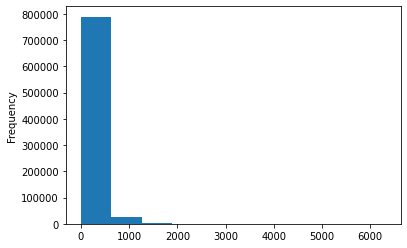

In [ ]:
train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split())).plot(kind='hist')

In [ ]:
train_raw['len_txt'] =train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split()))
train_raw.describe()

,Complaint ID,len_txt
count,8.216170e+05,821617.000000
mean,3.206297e+06,190.287933
std,8.708150e+05,226.916238
min,1.290155e+06,1.000000
25%,2.654470e+06,66.000000
50%,3.246880e+06,125.000000
75%,3.855518e+06,233.000000
max,4.885060e+06,6314.000000


In [ ]:
train_raw.shape

(821617, 19)

Select only the row with number of words greater than 250:

In [ ]:
train_raw = train_raw[train_raw.len_txt >249]
train_raw.shape

(186176, 19)

In [ ]:
train_raw = train_raw[['consumer_complaint_narrative', 'product']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,consumer_complaint_narrative,product
0,I contacted Ally on Friday XX/XX/XXXX after fa...,Vehicle loan or lease
1,Hello This complaint is against the three cred...,"Credit reporting, credit repair services, or o..."
2,Although I am checking for and addressing miss...,"Credit reporting, credit repair services, or o..."
3,"In an attempt to purchase concert tickets, I c...","Money transfer, virtual currency, or money ser..."
4,I am attempting to sell my home and pay off my...,Mortgage


Group similar products

In [ ]:
train_raw.at[train_raw['product'] == 'Credit reporting', 'product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
train_raw.at[train_raw['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
train_raw.at[train_raw['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
train_raw.head()

,consumer_complaint_narrative,product
0,I contacted Ally on Friday XX/XX/XXXX after fa...,Vehicle loan or lease
1,Hello This complaint is against the three cred...,"Credit reporting, credit repair services, or o..."
2,Although I am checking for and addressing miss...,"Credit reporting, credit repair services, or o..."
3,"In an attempt to purchase concert tickets, I c...","Money transfer, virtual currency, or money ser..."
4,I am attempting to sell my home and pay off my...,Mortgage


In [ ]:
for l in np.unique(train_raw['product']):
  print(l)

Bank account or service
Checking or savings account
Consumer Loan
Credit card or prepaid card
Credit reporting, credit repair services, or other personal consumer reports
Debt collection
Money transfer, virtual currency, or money service
Money transfers
Mortgage
Other financial service
Payday loan, title loan, or personal loan
Student loan
Vehicle loan or lease


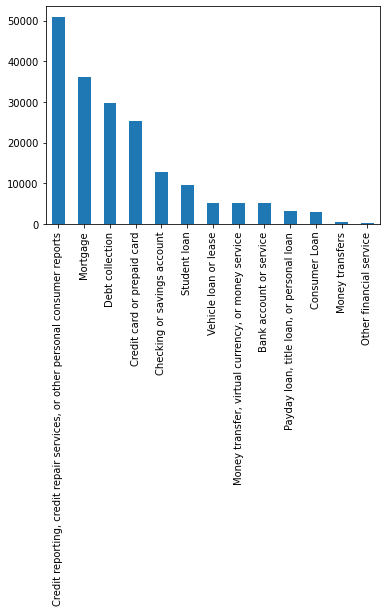

In [ ]:
train_raw['product'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [ ]:
train_raw=train_raw.rename(columns = {'consumer_complaint_narrative':'text', 'product':'label'})
train_raw.head()

,text,label
0,I contacted Ally on Friday XX/XX/XXXX after fa...,Vehicle loan or lease
1,Hello This complaint is against the three cred...,"Credit reporting, credit repair services, or o..."
2,Although I am checking for and addressing miss...,"Credit reporting, credit repair services, or o..."
3,"In an attempt to purchase concert tickets, I c...","Money transfer, virtual currency, or money ser..."
4,I am attempting to sell my home and pay off my...,Mortgage


In [ ]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()

,text,label
0,I contacted Ally on Friday XX/XX/XXXX after fa...,12
1,Hello This complaint is against the three cred...,4
2,Although I am checking for and addressing miss...,4
3,"In an attempt to purchase concert tickets, I c...",6
4,I am attempting to sell my home and pay off my...,8


In [ ]:
len(np.unique(train_raw['label']))

13

In [ ]:
train = train_raw.copy()
train = train[0:13713]

In [ ]:
train = train.reindex(np.random.permutation(train.index))
train.head()

,text,label
2197,I had an old account through XXXX XXXX that wa...,4
4304,DUPLICATE XXXX ACCOUNT {$890.00}??? \n\nIm con...,5
2022,"My name is XXXX XXXX, I enrolled in XXXX Unive...",5
7520,"Dear Legal Department, This credit dispute is ...",4
7882,Hello. I reported many charges as fraud early ...,3


Clean the text columns

In [ ]:
import re
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)    
  return text

In [ ]:
train['text']  = train.text.apply(clean_txt)
train.head()

,text,label
2197,I had an old account through XXXX XXXX that wa...,4
4304,DUPLICATE XXXX ACCOUNT 890 00 Im confused and ...,5
2022,My name is XXXX XXXX I enrolled in XXXX Univer...,5
7520,Dear Legal Department This credit dispute is b...,4
7882,Hello I reported many charges as fraud early X...,3


In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
train.head()

,text,label
4928,We have experienced several issues with this l...,10
5544,To Whom It May concern I am writing to dispute...,4
2633,On XX XX 2021 A Affidavit of Truth and Cease a...,5
8654,XX XX XXXX Resurgent Capital Services XXXX VAL...,5
410,Im having an issue with CitiCards When I make ...,3


In [ ]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label
0,We have experienced several issues with this l...,10
1,To Whom It May concern I am writing to dispute...,4


In [ ]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,text,label
0,I am having a problem resolving an overpayment...,3
1,On XX XX XXXX I went to where I bank locally t...,1


In [ ]:
val.shape, train.shape

((2743, 2), (10970, 2))

In [ ]:
#Installing BERT module
!pip install bert-tensorflow==1.0.1
#bert-tensorflow==1.0.1

In [ ]:
#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

# Setting The Output Directory for BERT

In [ ]:
# Set the output directory for saving model file
OUTPUT_DIR = '/bert_news_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /bert_news_category *****


In [ ]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (10970, 2)
Validation Set Shape : (2743, 2)


In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12]

# Splitting the Data into smaller chunks

In [ ]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,text,label,text_split
0,We have experienced several issues with this l...,10,[We have experienced several issues with this ...
1,To Whom It May concern I am writing to dispute...,4,[To Whom It May concern I am writing to disput...
2,On XX XX 2021 A Affidavit of Truth and Cease a...,5,[On XX XX 2021 A Affidavit of Truth and Cease ...
3,XX XX XXXX Resurgent Capital Services XXXX VAL...,5,[XX XX XXXX Resurgent Capital Services XXXX VA...
4,Im having an issue with CitiCards When I make ...,3,[Im having an issue with CitiCards When I make...


In [ ]:
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

,text,label,text_split
0,I am having a problem resolving an overpayment...,3,[I am having a problem resolving an overpaymen...
1,On XX XX XXXX I went to where I bank locally t...,1,[On XX XX XXXX I went to where I bank locally ...


In [ ]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(30322, 30322, 30322)

In [ ]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(7390, 7390, 7390)

The final dataset for training:

In [ ]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,We have experienced several issues with this l...,10
1,completed some notarized papers that I have no...,10
2,To Whom It May concern I am writing to dispute...,4
3,On XX XX 2021 A Affidavit of Truth and Cease a...,5
4,1692d 1 Upon further research and discovery I ...,5


In [ ]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,I am having a problem resolving an overpayment...,3
1,On XX XX XXXX I went to where I bank locally t...,1
2,XXXX XXXX know that I was not going to stay wi...,1
3,Their customer service rep confirmed they had ...,1
4,On XXXX XXXX XXXX a collection agency operatin...,1


# BERT: Data Preprocessing 

Process the data for BERT

In [ ]:
train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
train_InputExamples

0        <bert.run_classifier.InputExample object at 0x...
1        <bert.run_classifier.InputExample object at 0x...
2        <bert.run_classifier.InputExample object at 0x...
3        <bert.run_classifier.InputExample object at 0x...
4        <bert.run_classifier.InputExample object at 0x...
                               ...                        
30317    <bert.run_classifier.InputExample object at 0x...
30318    <bert.run_classifier.InputExample object at 0x...
30319    <bert.run_classifier.InputExample object at 0x...
30320    <bert.run_classifier.InputExample object at 0x...
30321    <bert.run_classifier.InputExample object at 0x...
Length: 30322, dtype: object

In [ ]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  We have experienced several issues with this lender mostly with communication and customer service Not being able to contact is the closest choice to what we are experiencing which is complete frustration I am extremely busy with a very demanding full time job I took out two rather small loans last winter with the help of my wife s research online One with this lender and another We are having no problems with the other lender who is very easy to deal with This lender has nothing but frustrating policies They will not talk to my wife even with my permission In the beginning when my wife tried to call even after I got on the line to give permission they gave her a hard time and when I emailed the to tell them I want my wife to be able to speak on all matters they refused unless I completed some notarized papers that I have no time for The other lender has no problem speaking with my wife after I gave this

# BERT: Loading the pre-trained model

In [ ]:

# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

In [ ]:
len(tokenizer.vocab.keys())

30522

In [ ]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['we', 'have', 'experienced', 'several', 'issues', 'with', 'this', 'lend', '##er', 'mostly', 'with', 'communication', 'and', 'customer', 'service', 'not', 'being', 'able', 'to', 'contact', 'is', 'the', 'closest', 'choice', 'to', 'what', 'we', 'are', 'experiencing', 'which', 'is', 'complete', 'frustration', 'i', 'am', 'extremely', 'busy', 'with', 'a', 'very', 'demanding', 'full', 'time', 'job', 'i', 'took', 'out', 'two', 'rather', 'small', 'loans', 'last', 'winter', 'with', 'the', 'help', 'of', 'my', 'wife', 's', 'research', 'online', 'one', 'with', 'this', 'lend', '##er', 'and', 'another', 'we', 'are', 'having', 'no', 'problems', 'with', 'the', 'other', 'lend', '##er', 'who', 'is', 'very', 'easy', 'to', 'deal', 'with', 'this', 'lend', '##er', 'has', 'nothing', 'but', 'frustrating', 'policies', 'they', 'will', 'not', 'talk', 'to', 'my', 'wife', 'even', 'with', 'my', 'permission', 'in', 'the', 'beginning', 'when', 'my', 'wife', 'tried', 'to', 'call', 'even', 'after', 'i', 'got', 'on', 't

In [ ]:
MAX_SEQ_LENGTH = 200

In [ ]:
# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

In [ ]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  We have experienced several issues with this lender mostly with communication and customer service Not being able to contact is the closest choice to what we are experiencing which is complete frustration I am extremely busy with a very demanding full time job I took out two rather small loans last winter with the help of my wife s research online One with this lender and another We are having no problems with the other lender who is very easy to deal with This lender has nothing but frustrating policies They will not talk to my wife even with my permission In the beginning when my wife tried to call even after I got on the line to give permission they gave her a hard time and when I emailed the to tell them I want my wife to be able to speak on all matters they refused unless I completed some notarized papers that I have no time for The other lender has no problem speaking with my wife after I gave this permission over the phone once when we took the loan Upstart will not 

# BERT: Creating A Multi-Class Classifier Model

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [ ]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
num_train_steps, len(label_list)

(1895, 12)

In [ ]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

# BERT: Fine Tuning Training & Evaluating

In [ ]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!


/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Training took time  0:14:34.116648


The accuracy for the fine tuned BERT model

In [ ]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


{'eval_accuracy': 0.79418135,
 'false_negatives': 0.0,
 'false_positives': 7.0,
 'global_step': 1895,
 'loss': 0.6375007,
 'true_negatives': 0.0,
 'true_positives': 7383.0}

# BERT: Get The Vector Transformations from the Fine Tuned BERT

In [ ]:
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])


In [ ]:
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
MAX_SEQ_LENGTH

200

In [ ]:
train_df.shape, val_df.shape

((30322, 2), (7390, 2))

Now extracting the representations:

In [ ]:
%%time
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))


CPU times: user 2min 31s, sys: 4.65 s, total: 2min 36s
Wall time: 6min 1s


In [ ]:
%%time
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))
val_emb.shape

CPU times: user 40.2 s, sys: 1.17 s, total: 41.3 s
Wall time: 1min 31s


In [ ]:
val_emb.shape, tr_emb.shape

((7390, 768), (30322, 768))

and make the dataset for train and val:

In [ ]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())


10970

In [ ]:
train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

,emb,label
0,"[[0.555614, -0.7043642, 0.23884456, -0.5593068...",10
1,"[[0.57215804, 0.85315824, -0.3633562, -0.00601...",4
2,"[[0.95516443, 0.3570898, 0.38249183, -0.696083...",5
3,"[[0.8143069, 0.5722994, 0.72764134, -0.2403974...",5
4,"[[0.370654, 0.9129017, 0.21963412, 0.58426046,...",3


In [ ]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
  if l in val_x.keys():
    val_x[l]  =np.vstack([val_x[l], emb])
  else:
    val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()

,emb,label
0,"[[-0.031965405, 0.92160696, -0.15463464, 0.743...",3
1,"[[0.44059056, -0.37587383, -0.91872317, 0.7310...",1
2,"[[0.9297317, 0.09239787, -0.68322265, 0.116566...",1
3,"[[-0.15868287, 0.8691171, 0.16583857, 0.785978...",3
4,"[[0.14659342, 0.9458528, 0.020829953, 0.564531...",3


In [ ]:
df_val, df_test = train_test_split(df_val, test_size=0.4, random_state=35)

# LSTM: Creating the Final Model

In [ ]:
from keras import layers
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, None, 768)         0         
_________________________________________________________________
masking_2 (Masking)          (None, None, 768)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               347600    
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_4 (Dense)              (None, 12)                372       
Total params: 351,002
Trainable params: 351,002
Non-trainable params: 0
_________________________________________________________________


In [ ]:
df_train.shape, df_val.shape, df_test.shape

((10970, 2), (1645, 2), (1098, 2))

The generator functions:

In [ ]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 5
batches_per_epoch =  2194
assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
num_sequences_val = len(df_val['emb'][:1639].to_list())
batch_size_val = 11
batches_per_epoch_val = 149
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

# LSTM Final Model: Training

In [ ]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [ ]:
model.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

Epoch 1/10
2194/2194 [==============================] - 16s 7ms/step - loss: nan - acc: 7.2926e-04 - val_loss: nan - val_acc: 0.0024
Epoch 2/10
2194/2194 [==============================] - 15s 7ms/step - loss: nan - acc: 3.6463e-04 - val_loss: nan - val_acc: 0.0024
Epoch 3/10
2194/2194 [==============================] - 15s 7ms/step - loss: nan - acc: 3.6463e-04 - val_loss: nan - val_acc: 0.0024
Epoch 4/10
2194/2194 [==============================] - 15s 7ms/step - loss: nan - acc: 3.6463e-04 - val_loss: nan - val_acc: 0.0024

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
Epoch 5/10
2194/2194 [==============================] - 15s 7ms/step - loss: nan - acc: 3.6463e-04 - val_loss: nan - val_acc: 0.0024
Epoch 6/10
2194/2194 [==============================] - 15s 7ms/step - loss: nan - acc: 3.6463e-04 - val_loss: nan - val_acc: 0.0024
Epoch 7/10
2194/2194 [==============================] - 15s 7ms/step - loss: nan - acc: 3.6463e-04 - val_loss: nan - val_

# LSTM Final Model: Evaluation



In [ ]:
num_sequences_val = len(df_test['emb'].to_list())
batch_size_val = 6
batches_per_epoch_val = 183
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)

[nan, 0.0]